In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['CAP'],
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_CAP_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(466039, 829)
(466039, 1)
validation
(80707, 829)
(80707, 1)
test
(46831, 829)
(46831, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 829)]             0         


 dense (Dense)               (None, 1024)              849920    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1539073 (5.87 MB)


Trainable params: 1539073 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 59s - loss: 0.0812 - STD: 2.7435e-04 - MAE: 0.2728

 4/47 [=>............................] - ETA: 1s - loss: 0.0411 - STD: 4.0087e-04 - MAE: 0.1545 

 5/47 [==>...........................] - ETA: 1s - loss: 0.0411 - STD: 3.6574e-04 - MAE: 0.1545

 6/47 [==>...........................] - ETA: 1s - loss: 0.0408 - STD: 3.4411e-04 - MAE: 0.1539

 7/47 [===>..........................] - ETA: 1s - loss: 0.0404 - STD: 3.3789e-04 - MAE: 0.1523

 8/47 [====>.........................] - ETA: 1s - loss: 0.0391 - STD: 3.4429e-04 - MAE: 0.1481

 9/47 [====>.........................] - ETA: 1s - loss: 0.0375 - STD: 3.6146e-04 - MAE: 0.1422

10/47 [=====>........................] - ETA: 1s - loss: 0.0357 - STD: 3.8706e-04 - MAE: 0.1357

11/47 [======>.......................] - ETA: 1s - loss: 0.0340 - STD: 4.1775e-04 - MAE: 0.1309

12/47 [======>.......................] - ETA: 1s - loss: 0.0326 - STD: 4.4909e-04 - MAE: 0.1286

13/47 [=======>......................] - ETA: 1s - loss: 0.0317 - STD: 4.8135e-04 - MAE: 0.1284

14/47 [=======>......................] - ETA: 1s - loss: 0.0311 - STD: 5.1276e-04 - MAE: 0.1291

15/47 [========>.....................] - ETA: 3s - loss: 0.0308 - STD: 5.4341e-04 - MAE: 0.1298

19/47 [===========>..................] - ETA: 2s - loss: 0.0283 - STD: 6.5146e-04 - MAE: 0.1250

20/47 [===========>..................] - ETA: 2s - loss: 0.0277 - STD: 6.7345e-04 - MAE: 0.1227

21/47 [============>.................] - ETA: 2s - loss: 0.0272 - STD: 6.9406e-04 - MAE: 0.1204

22/47 [=============>................] - ETA: 1s - loss: 0.0269 - STD: 7.1336e-04 - MAE: 0.1184

23/47 [=============>................] - ETA: 1s - loss: 0.0265 - STD: 7.3282e-04 - MAE: 0.1166

24/47 [==============>...............] - ETA: 1s - loss: 0.0262 - STD: 7.5301e-04 - MAE: 0.1149

25/47 [==============>...............] - ETA: 1s - loss: 0.0259 - STD: 7.7533e-04 - MAE: 0.1133

26/47 [===============>..............] - ETA: 1s - loss: 0.0256 - STD: 7.9988e-04 - MAE: 0.1118

27/47 [================>.............] - ETA: 1s - loss: 0.0252 - STD: 8.2654e-04 - MAE: 0.1105

28/47 [================>.............] - ETA: 1s - loss: 0.0249 - STD: 8.5549e-04 - MAE: 0.1094

29/47 [=================>............] - ETA: 1s - loss: 0.0246 - STD: 8.8718e-04 - MAE: 0.1086

30/47 [==================>...........] - ETA: 1s - loss: 0.0244 - STD: 9.2250e-04 - MAE: 0.1082

31/47 [==================>...........] - ETA: 1s - loss: 0.0242 - STD: 9.5923e-04 - MAE: 0.1079

32/47 [===================>..........] - ETA: 1s - loss: 0.0240 - STD: 9.9727e-04 - MAE: 0.1077

33/47 [====================>.........] - ETA: 1s - loss: 0.0238 - STD: 0.0010 - MAE: 0.1076    

34/47 [====================>.........] - ETA: 0s - loss: 0.0236 - STD: 0.0011 - MAE: 0.1075

35/47 [=====================>........] - ETA: 0s - loss: 0.0234 - STD: 0.0011 - MAE: 0.1072

36/47 [=====================>........] - ETA: 0s - loss: 0.0232 - STD: 0.0012 - MAE: 0.1068

37/47 [======================>.......] - ETA: 0s - loss: 0.0230 - STD: 0.0012 - MAE: 0.1063

39/47 [=======================>......] - ETA: 0s - loss: 0.0227 - STD: 0.0013 - MAE: 0.1051

40/47 [========================>.....] - ETA: 0s - loss: 0.0226 - STD: 0.0013 - MAE: 0.1045

41/47 [=========================>....] - ETA: 0s - loss: 0.0224 - STD: 0.0014 - MAE: 0.1038

42/47 [=========================>....] - ETA: 0s - loss: 0.0223 - STD: 0.0014 - MAE: 0.1032

43/47 [==========================>...] - ETA: 0s - loss: 0.0222 - STD: 0.0015 - MAE: 0.1026

44/47 [===========================>..] - ETA: 0s - loss: 0.0220 - STD: 0.0016 - MAE: 0.1021

45/47 [===========================>..] - ETA: 0s - loss: 0.0219 - STD: 0.0016 - MAE: 0.1016

46/47 [============================>.] - ETA: 0s - loss: 0.0218 - STD: 0.0017 - MAE: 0.1012

47/47 [==============================] - ETA: 0s - loss: 0.0217 - STD: 0.0018 - MAE: 0.1009

47/47 [==============================] - 5s 83ms/step - loss: 0.0217 - STD: 0.0018 - MAE: 0.1009 - val_loss: 0.0149 - val_STD: 0.0049 - val_MAE: 0.0759


Epoch 2/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0162 - STD: 0.0058 - MAE: 0.0891

 2/47 [>.............................] - ETA: 3s - loss: 0.0166 - STD: 0.0061 - MAE: 0.0909

 3/47 [>.............................] - ETA: 2s - loss: 0.0163 - STD: 0.0063 - MAE: 0.0908

 4/47 [=>............................] - ETA: 2s - loss: 0.0162 - STD: 0.0066 - MAE: 0.0908

 5/47 [==>...........................] - ETA: 2s - loss: 0.0161 - STD: 0.0069 - MAE: 0.0904

 7/47 [===>..........................] - ETA: 2s - loss: 0.0159 - STD: 0.0075 - MAE: 0.0889

 8/47 [====>.........................] - ETA: 2s - loss: 0.0158 - STD: 0.0078 - MAE: 0.0880

 9/47 [====>.........................] - ETA: 2s - loss: 0.0158 - STD: 0.0081 - MAE: 0.0870

10/47 [=====>........................] - ETA: 2s - loss: 0.0158 - STD: 0.0084 - MAE: 0.0862

11/47 [======>.......................] - ETA: 2s - loss: 0.0157 - STD: 0.0088 - MAE: 0.0854

12/47 [======>.......................] - ETA: 2s - loss: 0.0156 - STD: 0.0092 - MAE: 0.0846

13/47 [=======>......................] - ETA: 2s - loss: 0.0155 - STD: 0.0097 - MAE: 0.0840

14/47 [=======>......................] - ETA: 1s - loss: 0.0154 - STD: 0.0102 - MAE: 0.0836

15/47 [========>.....................] - ETA: 1s - loss: 0.0153 - STD: 0.0107 - MAE: 0.0833

16/47 [=========>....................] - ETA: 1s - loss: 0.0152 - STD: 0.0114 - MAE: 0.0830

17/47 [=========>....................] - ETA: 1s - loss: 0.0151 - STD: 0.0120 - MAE: 0.0828

18/47 [==========>...................] - ETA: 1s - loss: 0.0150 - STD: 0.0127 - MAE: 0.0827

19/47 [===========>..................] - ETA: 1s - loss: 0.0149 - STD: 0.0135 - MAE: 0.0824

20/47 [===========>..................] - ETA: 1s - loss: 0.0148 - STD: 0.0144 - MAE: 0.0822

21/47 [============>.................] - ETA: 1s - loss: 0.0147 - STD: 0.0152 - MAE: 0.0817

22/47 [=============>................] - ETA: 1s - loss: 0.0145 - STD: 0.0162 - MAE: 0.0813

23/47 [=============>................] - ETA: 1s - loss: 0.0144 - STD: 0.0172 - MAE: 0.0807

24/47 [==============>...............] - ETA: 1s - loss: 0.0143 - STD: 0.0182 - MAE: 0.0801

25/47 [==============>...............] - ETA: 1s - loss: 0.0141 - STD: 0.0193 - MAE: 0.0796

26/47 [===============>..............] - ETA: 1s - loss: 0.0140 - STD: 0.0206 - MAE: 0.0790

27/47 [================>.............] - ETA: 1s - loss: 0.0138 - STD: 0.0219 - MAE: 0.0785

28/47 [================>.............] - ETA: 1s - loss: 0.0136 - STD: 0.0233 - MAE: 0.0779

29/47 [=================>............] - ETA: 1s - loss: 0.0134 - STD: 0.0247 - MAE: 0.0774

30/47 [==================>...........] - ETA: 1s - loss: 0.0133 - STD: 0.0262 - MAE: 0.0768

31/47 [==================>...........] - ETA: 0s - loss: 0.0131 - STD: 0.0277 - MAE: 0.0763

32/47 [===================>..........] - ETA: 0s - loss: 0.0130 - STD: 0.0293 - MAE: 0.0757

33/47 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 0.0308 - MAE: 0.0752

34/47 [====================>.........] - ETA: 0s - loss: 0.0126 - STD: 0.0323 - MAE: 0.0746

35/47 [=====================>........] - ETA: 0s - loss: 0.0125 - STD: 0.0339 - MAE: 0.0740

36/47 [=====================>........] - ETA: 0s - loss: 0.0123 - STD: 0.0354 - MAE: 0.0735

37/47 [======================>.......] - ETA: 0s - loss: 0.0122 - STD: 0.0369 - MAE: 0.0729

38/47 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 0.0384 - MAE: 0.0724

39/47 [=======================>......] - ETA: 0s - loss: 0.0119 - STD: 0.0398 - MAE: 0.0719

40/47 [========================>.....] - ETA: 0s - loss: 0.0117 - STD: 0.0413 - MAE: 0.0714

41/47 [=========================>....] - ETA: 0s - loss: 0.0116 - STD: 0.0426 - MAE: 0.0709

42/47 [=========================>....] - ETA: 0s - loss: 0.0114 - STD: 0.0439 - MAE: 0.0704

43/47 [==========================>...] - ETA: 0s - loss: 0.0113 - STD: 0.0451 - MAE: 0.0699

44/47 [===========================>..] - ETA: 0s - loss: 0.0112 - STD: 0.0464 - MAE: 0.0694

45/47 [===========================>..] - ETA: 0s - loss: 0.0110 - STD: 0.0476 - MAE: 0.0690

46/47 [============================>.] - ETA: 0s - loss: 0.0109 - STD: 0.0488 - MAE: 0.0686

47/47 [==============================] - ETA: 0s - loss: 0.0108 - STD: 0.0500 - MAE: 0.0681

47/47 [==============================] - 3s 67ms/step - loss: 0.0108 - STD: 0.0500 - MAE: 0.0681 - val_loss: 0.0048 - val_STD: 0.0855 - val_MAE: 0.0463


Epoch 3/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.1045 - MAE: 0.0473

 2/47 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.1044 - MAE: 0.0473

 3/47 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.1038 - MAE: 0.0472

 4/47 [=>............................] - ETA: 2s - loss: 0.0053 - STD: 0.1041 - MAE: 0.0475

 5/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.1049 - MAE: 0.0475

 6/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.1060 - MAE: 0.0475

 7/47 [===>..........................] - ETA: 2s - loss: 0.0052 - STD: 0.1066 - MAE: 0.0474

 8/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.1066 - MAE: 0.0472

 9/47 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.1064 - MAE: 0.0470

10/47 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.1064 - MAE: 0.0468

11/47 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.1065 - MAE: 0.0467

12/47 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.1069 - MAE: 0.0467

13/47 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.1071 - MAE: 0.0467

14/47 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.1074 - MAE: 0.0465

16/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.1077 - MAE: 0.0463

17/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.1078 - MAE: 0.0463

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.1079 - MAE: 0.0462

19/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.1079 - MAE: 0.0461

20/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.1081 - MAE: 0.0460

21/47 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.1082 - MAE: 0.0460

22/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.1085 - MAE: 0.0460

23/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.1084 - MAE: 0.0459

24/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.1085 - MAE: 0.0458

25/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.1086 - MAE: 0.0457

26/47 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.1087 - MAE: 0.0457

27/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.1089 - MAE: 0.0457

28/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.1089 - MAE: 0.0456

29/47 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.1089 - MAE: 0.0456

30/47 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.1090 - MAE: 0.0455

31/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.1092 - MAE: 0.0455

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.1094 - MAE: 0.0454

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.1095 - MAE: 0.0454

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.1095 - MAE: 0.0454

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.1096 - MAE: 0.0453

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.1097 - MAE: 0.0452

37/47 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.1098 - MAE: 0.0452

38/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.1099 - MAE: 0.0451

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.1100 - MAE: 0.0451

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.1100 - MAE: 0.0450

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.1101 - MAE: 0.0449

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.1102 - MAE: 0.0449

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.1103 - MAE: 0.0448

44/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.1103 - MAE: 0.0448

45/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.1103 - MAE: 0.0447

46/47 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.1104 - MAE: 0.0447

47/47 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.1105 - MAE: 0.0446

47/47 [==============================] - 3s 66ms/step - loss: 0.0045 - STD: 0.1105 - MAE: 0.0446 - val_loss: 0.0041 - val_STD: 0.0928 - val_MAE: 0.0430


Epoch 4/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.1142 - MAE: 0.0431

 2/47 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.1137 - MAE: 0.0422

 3/47 [>.............................] - ETA: 2s - loss: 0.0039 - STD: 0.1140 - MAE: 0.0423

 5/47 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.1139 - MAE: 0.0422

 6/47 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.1137 - MAE: 0.0421

 7/47 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.1138 - MAE: 0.0421

 8/47 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.1135 - MAE: 0.0420

 9/47 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.1131 - MAE: 0.0419

10/47 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.1133 - MAE: 0.0418

11/47 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.1139 - MAE: 0.0417

12/47 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.1140 - MAE: 0.0417

13/47 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.1140 - MAE: 0.0417

14/47 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.1139 - MAE: 0.0416

15/47 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.1142 - MAE: 0.0415

16/47 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.1144 - MAE: 0.0415

17/47 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.1143 - MAE: 0.0414

18/47 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.1144 - MAE: 0.0414

19/47 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.1143 - MAE: 0.0414

20/47 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.1143 - MAE: 0.0413

21/47 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.1143 - MAE: 0.0412

22/47 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.1143 - MAE: 0.0412

23/47 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.1143 - MAE: 0.0412

24/47 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.1144 - MAE: 0.0412

25/47 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.1144 - MAE: 0.0411

26/47 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.1144 - MAE: 0.0411

27/47 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.1144 - MAE: 0.0410

28/47 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.1146 - MAE: 0.0410

29/47 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.1146 - MAE: 0.0409

30/47 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.1146 - MAE: 0.0409

31/47 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.1146 - MAE: 0.0409

32/47 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.1148 - MAE: 0.0408

33/47 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.1148 - MAE: 0.0408

34/47 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.1147 - MAE: 0.0408

35/47 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.1148 - MAE: 0.0407

36/47 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.1148 - MAE: 0.0407

37/47 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.1148 - MAE: 0.0407

38/47 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.1148 - MAE: 0.0406

39/47 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.1148 - MAE: 0.0406

40/47 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.1149 - MAE: 0.0405

41/47 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.1149 - MAE: 0.0405

42/47 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.1149 - MAE: 0.0405

43/47 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.1149 - MAE: 0.0404

44/47 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.1150 - MAE: 0.0404

45/47 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.1151 - MAE: 0.0404

46/47 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.1150 - MAE: 0.0403

47/47 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.1151 - MAE: 0.0403

47/47 [==============================] - 3s 67ms/step - loss: 0.0035 - STD: 0.1151 - MAE: 0.0403 - val_loss: 0.0038 - val_STD: 0.0980 - val_MAE: 0.0401


Epoch 5/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.1157 - MAE: 0.0381

 2/47 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.1158 - MAE: 0.0383

 3/47 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.1149 - MAE: 0.0384

 5/47 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.1154 - MAE: 0.0385

 6/47 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.1157 - MAE: 0.0386

 7/47 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.1163 - MAE: 0.0385

 8/47 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.1165 - MAE: 0.0385

 9/47 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.1162 - MAE: 0.0385

10/47 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.1162 - MAE: 0.0385

11/47 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.1169 - MAE: 0.0385

12/47 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.1169 - MAE: 0.0385

13/47 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.1166 - MAE: 0.0385

14/47 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.1169 - MAE: 0.0385

15/47 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.1171 - MAE: 0.0385

16/47 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.1169 - MAE: 0.0385

17/47 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.1169 - MAE: 0.0385

18/47 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.1172 - MAE: 0.0385

19/47 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.1172 - MAE: 0.0384

20/47 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.1172 - MAE: 0.0384

21/47 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.1173 - MAE: 0.0384

22/47 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.1175 - MAE: 0.0383

23/47 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.1173 - MAE: 0.0383

24/47 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1173 - MAE: 0.0383

25/47 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1173 - MAE: 0.0383

26/47 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.1172 - MAE: 0.0383

27/47 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.1173 - MAE: 0.0383

28/47 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.1173 - MAE: 0.0383

29/47 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.1172 - MAE: 0.0383

30/47 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.1174 - MAE: 0.0382

31/47 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.1174 - MAE: 0.0382

32/47 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.1175 - MAE: 0.0382

33/47 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1175 - MAE: 0.0382

34/47 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1175 - MAE: 0.0382

36/47 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1176 - MAE: 0.0382

37/47 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1176 - MAE: 0.0382

38/47 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1175 - MAE: 0.0382

39/47 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1176 - MAE: 0.0381

40/47 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1177 - MAE: 0.0381

41/47 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1177 - MAE: 0.0381

42/47 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1177 - MAE: 0.0381

43/47 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1178 - MAE: 0.0381

44/47 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1178 - MAE: 0.0380

45/47 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1177 - MAE: 0.0380

46/47 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1177 - MAE: 0.0380

47/47 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1177 - MAE: 0.0380

47/47 [==============================] - 3s 67ms/step - loss: 0.0031 - STD: 0.1177 - MAE: 0.0380 - val_loss: 0.0035 - val_STD: 0.0988 - val_MAE: 0.0384


Epoch 6/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.1172 - MAE: 0.0373

 2/47 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.1177 - MAE: 0.0368

 3/47 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.1166 - MAE: 0.0369

 4/47 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.1168 - MAE: 0.0370

 5/47 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.1171 - MAE: 0.0370

 7/47 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.1180 - MAE: 0.0370

 8/47 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0369

 9/47 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.1185 - MAE: 0.0369

10/47 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.1187 - MAE: 0.0369

11/47 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.1186 - MAE: 0.0369

12/47 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.1185 - MAE: 0.0369

13/47 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.1181 - MAE: 0.0369

14/47 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0369

15/47 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.1182 - MAE: 0.0369

16/47 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.1182 - MAE: 0.0369

17/47 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.1182 - MAE: 0.0369

18/47 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.1182 - MAE: 0.0369

19/47 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.1182 - MAE: 0.0369

20/47 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0369

21/47 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.1182 - MAE: 0.0368

22/47 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1181 - MAE: 0.0369

23/47 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0369

24/47 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0369

25/47 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0368

26/47 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0368

27/47 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0368

28/47 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0368

29/47 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.1186 - MAE: 0.0368

30/47 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.1185 - MAE: 0.0368

31/47 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.1186 - MAE: 0.0368

32/47 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1185 - MAE: 0.0368

33/47 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1185 - MAE: 0.0368

34/47 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1186 - MAE: 0.0368

35/47 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1185 - MAE: 0.0368

36/47 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1186 - MAE: 0.0368

37/47 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1187 - MAE: 0.0368

38/47 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1186 - MAE: 0.0367

39/47 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1187 - MAE: 0.0367

40/47 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1187 - MAE: 0.0367

41/47 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1186 - MAE: 0.0367

42/47 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1186 - MAE: 0.0367

43/47 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1185 - MAE: 0.0367

44/47 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1186 - MAE: 0.0367

45/47 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1185 - MAE: 0.0366

46/47 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1185 - MAE: 0.0366

47/47 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1186 - MAE: 0.0366

47/47 [==============================] - 3s 67ms/step - loss: 0.0028 - STD: 0.1186 - MAE: 0.0366 - val_loss: 0.0035 - val_STD: 0.1011 - val_MAE: 0.0376


Epoch 7/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.1210 - MAE: 0.0363

 2/47 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.1193 - MAE: 0.0363

 3/47 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.1200 - MAE: 0.0363

 4/47 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.1202 - MAE: 0.0363

 5/47 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.1195 - MAE: 0.0363

 6/47 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.1196 - MAE: 0.0362

 7/47 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.1199 - MAE: 0.0361

 8/47 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.1195 - MAE: 0.0360

 9/47 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.1193 - MAE: 0.0360

10/47 [=====>........................] - ETA: 2s - loss: 0.0028 - STD: 0.1196 - MAE: 0.0361

11/47 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.1192 - MAE: 0.0361

12/47 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.1198 - MAE: 0.0362

13/47 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.1194 - MAE: 0.0362

14/47 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.1196 - MAE: 0.0362

15/47 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.1195 - MAE: 0.0362

16/47 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.1196 - MAE: 0.0361

17/47 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.1197 - MAE: 0.0362

18/47 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.1193 - MAE: 0.0362

19/47 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.1195 - MAE: 0.0362

20/47 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.1195 - MAE: 0.0361

21/47 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.1193 - MAE: 0.0361

22/47 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1194 - MAE: 0.0361

24/47 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1191 - MAE: 0.0361

25/47 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1193 - MAE: 0.0361

26/47 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.1189 - MAE: 0.0362

27/47 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1190 - MAE: 0.0362

28/47 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1191 - MAE: 0.0361

29/47 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.1189 - MAE: 0.0362

30/47 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1190 - MAE: 0.0362

31/47 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.1191 - MAE: 0.0362

32/47 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1189 - MAE: 0.0362

33/47 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1190 - MAE: 0.0362

34/47 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1190 - MAE: 0.0362

35/47 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1188 - MAE: 0.0362

36/47 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1190 - MAE: 0.0362

37/47 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1190 - MAE: 0.0362

38/47 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1191 - MAE: 0.0362

39/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0362

40/47 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0362

41/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0361

42/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0361

43/47 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0361

44/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0361

45/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0361

46/47 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0360

47/47 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0360

47/47 [==============================] - 3s 66ms/step - loss: 0.0027 - STD: 0.1192 - MAE: 0.0360 - val_loss: 0.0034 - val_STD: 0.1022 - val_MAE: 0.0366


Epoch 8/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1187 - MAE: 0.0346

 2/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1207 - MAE: 0.0349

 3/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1195 - MAE: 0.0352

 4/47 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0352

 5/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0352

 6/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0351

 7/47 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0351

 8/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0352

 9/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1204 - MAE: 0.0351

10/47 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0351

11/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0351

12/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0351

13/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0350

14/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0350

15/47 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.1203 - MAE: 0.0350

16/47 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1205 - MAE: 0.0350

17/47 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1204 - MAE: 0.0350

18/47 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1204 - MAE: 0.0350

19/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1204 - MAE: 0.0350

20/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1203 - MAE: 0.0350

21/47 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1204 - MAE: 0.0350

22/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1203 - MAE: 0.0350

23/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1204 - MAE: 0.0351

24/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1204 - MAE: 0.0350

25/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1204 - MAE: 0.0350

26/47 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1203 - MAE: 0.0350

27/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0351

28/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0351

29/47 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0351

30/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0351

31/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0351

32/47 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0351

33/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0351

34/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0351

36/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0350

37/47 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0350

38/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0350

39/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0350

40/47 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0351

41/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0351

42/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0351

43/47 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0351

44/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0351

45/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0351

46/47 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0351

47/47 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0351

47/47 [==============================] - 3s 68ms/step - loss: 0.0026 - STD: 0.1199 - MAE: 0.0351 - val_loss: 0.0034 - val_STD: 0.1018 - val_MAE: 0.0363


Epoch 9/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1211 - MAE: 0.0352

 2/47 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1190 - MAE: 0.0354

 3/47 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1198 - MAE: 0.0355

 4/47 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.1195 - MAE: 0.0357

 5/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0355

 6/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1194 - MAE: 0.0355

 7/47 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.1197 - MAE: 0.0354

 8/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0353

10/47 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0353

11/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0352

12/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0351

13/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0351

14/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0351

15/47 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.1196 - MAE: 0.0350

16/47 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1197 - MAE: 0.0350

17/47 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1196 - MAE: 0.0351

18/47 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0352

19/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1194 - MAE: 0.0355

20/47 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.1197 - MAE: 0.0356

21/47 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1194 - MAE: 0.0357

22/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1196 - MAE: 0.0356

23/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0356

24/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1197 - MAE: 0.0357

25/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0356

26/47 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0356

27/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0356

28/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0356

29/47 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0355

30/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0355

31/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0355

32/47 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0354

33/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0354

34/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0354

35/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0354

36/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0353

37/47 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0353

38/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0353

39/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0353

40/47 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0352

41/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0352

42/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0352

43/47 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0352

44/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0352

45/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0352

46/47 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0352

47/47 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0352

47/47 [==============================] - 3s 67ms/step - loss: 0.0026 - STD: 0.1202 - MAE: 0.0352 - val_loss: 0.0035 - val_STD: 0.1034 - val_MAE: 0.0360


Epoch 10/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.1232 - MAE: 0.0352

 2/47 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.1201 - MAE: 0.0355

 3/47 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1221 - MAE: 0.0354

 4/47 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1209 - MAE: 0.0355

 5/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1215 - MAE: 0.0353

 6/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1215 - MAE: 0.0351

 7/47 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.1209 - MAE: 0.0352

 8/47 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1212 - MAE: 0.0354

10/47 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0355

11/47 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1203 - MAE: 0.0356

12/47 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.1197 - MAE: 0.0360

13/47 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1201 - MAE: 0.0359

14/47 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0358

15/47 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1198 - MAE: 0.0361

16/47 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1201 - MAE: 0.0361

17/47 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1200 - MAE: 0.0360

18/47 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.1200 - MAE: 0.0360

19/47 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1200 - MAE: 0.0359

20/47 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1202 - MAE: 0.0359

21/47 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0358

22/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1204 - MAE: 0.0358

23/47 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.1203 - MAE: 0.0357

24/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0357

25/47 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0357

26/47 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1203 - MAE: 0.0356

27/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0356

28/47 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1203 - MAE: 0.0355

29/47 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0355

30/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1203 - MAE: 0.0354

31/47 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0354

32/47 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0353

33/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0353

34/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0353

35/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0353

36/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0353

37/47 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0353

38/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0352

39/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1203 - MAE: 0.0352

40/47 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0353

41/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0353

42/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1203 - MAE: 0.0352

43/47 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0352

44/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0352

45/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0352

46/47 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0352

47/47 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0352

47/47 [==============================] - 3s 69ms/step - loss: 0.0026 - STD: 0.1202 - MAE: 0.0352 - val_loss: 0.0033 - val_STD: 0.1004 - val_MAE: 0.0366


Epoch 11/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1196 - MAE: 0.0347

 2/47 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1186 - MAE: 0.0345

 3/47 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1190 - MAE: 0.0345

 4/47 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.1191 - MAE: 0.0346

 5/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1196 - MAE: 0.0346

 6/47 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.1196 - MAE: 0.0346

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1195 - MAE: 0.0346

 8/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1199 - MAE: 0.0346

 9/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1199 - MAE: 0.0346

10/47 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1198 - MAE: 0.0345

11/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0345

12/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0344

13/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0345

14/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0345

15/47 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0345

16/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1201 - MAE: 0.0345

17/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0345

18/47 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0345

19/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0345

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0345

21/47 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0345

22/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0344

23/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0344

24/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0345

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0345

26/47 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0345

27/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0345

28/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0345

29/47 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0345

30/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0345

31/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0346

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0347

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0347

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1201 - MAE: 0.0347

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0347

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0347

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0347

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0347

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0347

41/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0347

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0347

43/47 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0347

44/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0347

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0347

46/47 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0348

47/47 [==============================] - 3s 67ms/step - loss: 0.0025 - STD: 0.1205 - MAE: 0.0348 - val_loss: 0.0034 - val_STD: 0.1019 - val_MAE: 0.0362


Epoch 12/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1223 - MAE: 0.0345

 2/47 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1218 - MAE: 0.0346

 3/47 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1220 - MAE: 0.0343

 4/47 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.1220 - MAE: 0.0342

 5/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0342

 6/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0342

 7/47 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

 8/47 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0341

 9/47 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

10/47 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0342

11/47 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0342

12/47 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0342

13/47 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0342

14/47 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0343

15/47 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0343

16/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0343

17/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0342

18/47 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0343

19/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0342

20/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

22/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

23/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0342

24/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0343

25/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

26/47 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

27/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0343

28/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

29/47 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

30/47 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

31/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0342

32/47 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0342

33/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0342

34/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0342

35/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0342

36/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0342

37/47 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1205 - MAE: 0.0342

38/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1204 - MAE: 0.0342

39/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1205 - MAE: 0.0343

40/47 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1205 - MAE: 0.0343

41/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1205 - MAE: 0.0343

42/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0343

43/47 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0344

44/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0343

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0343

46/47 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0343

47/47 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0344

47/47 [==============================] - 3s 67ms/step - loss: 0.0024 - STD: 0.1208 - MAE: 0.0344 - val_loss: 0.0035 - val_STD: 0.0977 - val_MAE: 0.0405


Epoch 13/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.1167 - MAE: 0.0370

 2/47 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1202 - MAE: 0.0361

 3/47 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1207 - MAE: 0.0358

 4/47 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0354

 5/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1209 - MAE: 0.0354

 6/47 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0354

 7/47 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0352

 9/47 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1196 - MAE: 0.0350

10/47 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1198 - MAE: 0.0350

11/47 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1197 - MAE: 0.0349

13/47 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0348

14/47 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0348

15/47 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0348

17/47 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1199 - MAE: 0.0349

18/47 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1201 - MAE: 0.0349

19/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0348

20/47 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1201 - MAE: 0.0348

21/47 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0348

22/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0348

23/47 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1201 - MAE: 0.0348

24/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0348

25/47 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0349

26/47 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0348

27/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0348

28/47 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0349

30/47 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0348

31/47 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0348

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0348

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0348

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0347

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0347

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0347

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0347

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0347

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0347

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0346

41/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0346

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0346

43/47 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0346

44/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0346

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0346

46/47 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0346

47/47 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0346

47/47 [==============================] - 3s 65ms/step - loss: 0.0025 - STD: 0.1207 - MAE: 0.0346 - val_loss: 0.0033 - val_STD: 0.1000 - val_MAE: 0.0375


Epoch 14/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.1190 - MAE: 0.0337

 3/47 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1209 - MAE: 0.0336

 4/47 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.1207 - MAE: 0.0338

 5/47 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.1208 - MAE: 0.0338

 6/47 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0339

 7/47 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.1204 - MAE: 0.0343

 8/47 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0344

 9/47 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0344

10/47 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0343

11/47 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0344

12/47 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0344

13/47 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0344

14/47 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0344

15/47 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0345

16/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0345

17/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0345

18/47 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0344

19/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0345

20/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0345

21/47 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0345

22/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0344

23/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0344

24/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0344

25/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0344

26/47 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0343

27/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0343

28/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0343

29/47 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0343

30/47 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0343

31/47 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

32/47 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

33/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

34/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

35/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

36/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

37/47 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

38/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

39/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

40/47 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

41/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

42/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

43/47 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

44/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

46/47 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

47/47 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

47/47 [==============================] - 3s 69ms/step - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342 - val_loss: 0.0034 - val_STD: 0.1016 - val_MAE: 0.0366


Epoch 15/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.1204 - MAE: 0.0334

 2/47 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0338

 3/47 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1205 - MAE: 0.0338

 4/47 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0339

 5/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0341

 6/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0345

 7/47 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0346

 8/47 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0346

 9/47 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0344

10/47 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0344

11/47 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0344

12/47 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0344

13/47 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0344

14/47 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0344

15/47 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0343

16/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0343

17/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0343

18/47 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0343

19/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0343

20/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0343

21/47 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0343

22/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0343

23/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0343

24/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0343

25/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0343

26/47 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0343

27/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

28/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

29/47 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

30/47 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

31/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

32/47 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

33/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

34/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

35/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

36/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

37/47 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

38/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

39/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

40/47 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

41/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

42/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0341

44/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0341

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0341

46/47 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0341

47/47 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0342

47/47 [==============================] - 3s 66ms/step - loss: 0.0024 - STD: 0.1211 - MAE: 0.0342 - val_loss: 0.0034 - val_STD: 0.0984 - val_MAE: 0.0390


Epoch 16/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.1165 - MAE: 0.0350

 2/47 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1193 - MAE: 0.0341

 3/47 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0340

 4/47 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.1200 - MAE: 0.0344

 5/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0346

 6/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0345

 7/47 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.1217 - MAE: 0.0344

 8/47 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0343

 9/47 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0343

10/47 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0344

11/47 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

12/47 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0342

13/47 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0341

14/47 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0341

15/47 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0341

16/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0341

17/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

18/47 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0342

19/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0341

20/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

21/47 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0340

22/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0340

23/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0340

24/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0340

25/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0340

26/47 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0340

27/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0339

28/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0339

29/47 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0339

30/47 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0339

31/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0339

32/47 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0340

34/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0341

35/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

36/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

37/47 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0342

38/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0342

39/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0342

40/47 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0342

41/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0342

42/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0342

43/47 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

44/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0341

46/47 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0341

47/47 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0341

47/47 [==============================] - 3s 66ms/step - loss: 0.0024 - STD: 0.1211 - MAE: 0.0341 - val_loss: 0.0034 - val_STD: 0.1002 - val_MAE: 0.0385


Epoch 17/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.1200 - MAE: 0.0342

 2/47 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1221 - MAE: 0.0341

 3/47 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0339

 4/47 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0339

 5/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0339

 6/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0340

 7/47 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0339

 8/47 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0340

 9/47 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0340

10/47 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0340

11/47 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0340

12/47 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0340

13/47 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0340

14/47 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0340

15/47 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0340

16/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0340

17/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0339

18/47 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0339

19/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0339

20/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0340

21/47 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0341

22/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

23/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0343

24/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0343

25/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0343

26/47 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0343

27/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0344

28/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0344

29/47 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0344

30/47 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0344

31/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0344

32/47 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0344

33/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0344

34/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0343

35/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0343

36/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0343

37/47 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0343

38/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0343

39/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0343

41/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

42/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

43/47 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

46/47 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0342

47/47 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0341

47/47 [==============================] - 3s 66ms/step - loss: 0.0024 - STD: 0.1210 - MAE: 0.0341 - val_loss: 0.0033 - val_STD: 0.1014 - val_MAE: 0.0363


Epoch 18/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.1208 - MAE: 0.0330

 2/47 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1202 - MAE: 0.0334

 3/47 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1206 - MAE: 0.0335

 4/47 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.1199 - MAE: 0.0337

 5/47 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.1199 - MAE: 0.0336

 6/47 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.1201 - MAE: 0.0336

 7/47 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.1196 - MAE: 0.0336

 8/47 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.1202 - MAE: 0.0336

 9/47 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.1202 - MAE: 0.0336

10/47 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.1203 - MAE: 0.0336

11/47 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1203 - MAE: 0.0337

12/47 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1203 - MAE: 0.0338

13/47 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1206 - MAE: 0.0338

14/47 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1206 - MAE: 0.0338

15/47 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.1206 - MAE: 0.0338

16/47 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.1207 - MAE: 0.0338

17/47 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.1206 - MAE: 0.0338

18/47 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.1206 - MAE: 0.0338

19/47 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.1206 - MAE: 0.0339

20/47 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.1205 - MAE: 0.0338

21/47 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.1207 - MAE: 0.0339

22/47 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1206 - MAE: 0.0339

23/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0339

24/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0340

25/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0340

26/47 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0340

27/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0340

28/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0340

29/47 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0340

30/47 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0339

31/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0339

32/47 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0339

33/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0339

34/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0339

35/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0339

36/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0339

37/47 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0339

38/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0340

40/47 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0340

41/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0340

42/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0340

43/47 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0339

44/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0339

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0339

46/47 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0339

47/47 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0339

47/47 [==============================] - 3s 65ms/step - loss: 0.0024 - STD: 0.1212 - MAE: 0.0339 - val_loss: 0.0033 - val_STD: 0.1024 - val_MAE: 0.0357


Epoch 19/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0335

 2/47 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1204 - MAE: 0.0336

 3/47 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0337

 4/47 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0339

 5/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0339

 6/47 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.1220 - MAE: 0.0339

 7/47 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.1221 - MAE: 0.0339

 8/47 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.1222 - MAE: 0.0339

 9/47 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0338

10/47 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0338

11/47 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0338

12/47 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0338

13/47 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0339

14/47 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0338

15/47 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0338

16/47 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.1218 - MAE: 0.0338

17/47 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0340

18/47 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.1219 - MAE: 0.0340

19/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0340

20/47 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0340

21/47 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0340

23/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0341

24/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0341

25/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0341

26/47 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0341

27/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0341

28/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0342

29/47 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0342

30/47 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0341

32/47 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0342

34/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0341

35/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0342

36/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0342

37/47 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0342

38/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0341

39/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0341

40/47 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0341

41/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0341

42/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0341

43/47 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0341

44/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0341

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0340

46/47 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0340

47/47 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0340

47/47 [==============================] - 3s 66ms/step - loss: 0.0024 - STD: 0.1211 - MAE: 0.0340 - val_loss: 0.0033 - val_STD: 0.0999 - val_MAE: 0.0374


Epoch 20/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.1171 - MAE: 0.0334

 2/47 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1191 - MAE: 0.0336

 3/47 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1201 - MAE: 0.0334

 4/47 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.1205 - MAE: 0.0333

 5/47 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.1209 - MAE: 0.0333

 6/47 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.1206 - MAE: 0.0334

 7/47 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.1208 - MAE: 0.0334

 8/47 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0334

 9/47 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0336

10/47 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0336

11/47 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0337

12/47 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0336

13/47 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0336

15/47 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0337

16/47 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.1209 - MAE: 0.0337

17/47 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.1209 - MAE: 0.0336

18/47 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0336

19/47 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.1210 - MAE: 0.0336

20/47 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0336

21/47 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0336

22/47 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0336

23/47 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1210 - MAE: 0.0336

24/47 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1210 - MAE: 0.0336

25/47 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0336

26/47 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0336

27/47 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0336

28/47 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0335

29/47 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0335

30/47 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0336

31/47 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1210 - MAE: 0.0336

32/47 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0336

33/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0337

34/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0337

35/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0337

36/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0337

37/47 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0337

38/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0337

39/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0336

40/47 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0336

41/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0336

42/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0336

43/47 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0336

44/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0336

45/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0336

46/47 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0336

47/47 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0336

47/47 [==============================] - 3s 68ms/step - loss: 0.0023 - STD: 0.1213 - MAE: 0.0336 - val_loss: 0.0034 - val_STD: 0.1038 - val_MAE: 0.0355


Epoch 21/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.1245 - MAE: 0.0341

 2/47 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0342

 3/47 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1217 - MAE: 0.0340

 4/47 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0338

 5/47 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.1222 - MAE: 0.0336

 6/47 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.1225 - MAE: 0.0337

 7/47 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0338

 8/47 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.1221 - MAE: 0.0339

 9/47 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0339

10/47 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0338

11/47 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1221 - MAE: 0.0338

13/47 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1222 - MAE: 0.0340

14/47 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.1218 - MAE: 0.0341

15/47 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.1218 - MAE: 0.0341

16/47 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.1218 - MAE: 0.0340

17/47 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0341

18/47 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.1218 - MAE: 0.0341

19/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0342

20/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1217 - MAE: 0.0341

21/47 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1218 - MAE: 0.0341

22/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0342

23/47 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1217 - MAE: 0.0342

24/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0343

25/47 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0342

26/47 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0342

27/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0343

28/47 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0343

29/47 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0342

30/47 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0342

31/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0342

32/47 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0342

33/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0341

34/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0341

35/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0340

36/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0340

37/47 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0340

38/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0339

39/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0339

40/47 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0339

41/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0339

42/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0339

43/47 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0339

44/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0339

45/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0339

46/47 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0339

47/47 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0339

47/47 [==============================] - 3s 66ms/step - loss: 0.0023 - STD: 0.1213 - MAE: 0.0339 - val_loss: 0.0033 - val_STD: 0.1017 - val_MAE: 0.0370


Epoch 22/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.1241 - MAE: 0.0338

 2/47 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1222 - MAE: 0.0335

 3/47 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1209 - MAE: 0.0332

 4/47 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.1218 - MAE: 0.0332

 5/47 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0332

 6/47 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.1222 - MAE: 0.0332

 7/47 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0332

 8/47 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.1218 - MAE: 0.0332

10/47 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0332

11/47 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1220 - MAE: 0.0332

12/47 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1221 - MAE: 0.0332

13/47 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0332

14/47 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0332

15/47 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0333

16/47 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0333

17/47 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0333

18/47 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0333

19/47 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0333

20/47 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0333

22/47 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0333

23/47 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0333

24/47 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0334

25/47 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0334

26/47 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0334

27/47 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0334

28/47 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0335

29/47 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1218 - MAE: 0.0335

30/47 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0336

31/47 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1218 - MAE: 0.0336

32/47 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0336

33/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0336

34/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0335

35/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0335

36/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0335

37/47 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0335

38/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0335

39/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0335

40/47 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0335

41/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0334

42/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0334

43/47 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0335

44/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0335

45/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0336

46/47 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0336

47/47 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0336

47/47 [==============================] - 3s 67ms/step - loss: 0.0023 - STD: 0.1215 - MAE: 0.0336 - val_loss: 0.0033 - val_STD: 0.1015 - val_MAE: 0.0367


Epoch 23/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.1203 - MAE: 0.0335

 2/47 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.1201 - MAE: 0.0330

 3/47 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.1210 - MAE: 0.0330

 4/47 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.1207 - MAE: 0.0331

 5/47 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0331

 6/47 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.1210 - MAE: 0.0331

 7/47 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0331

 9/47 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.1208 - MAE: 0.0331

10/47 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.1208 - MAE: 0.0330

11/47 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1206 - MAE: 0.0330

12/47 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1204 - MAE: 0.0330

13/47 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1204 - MAE: 0.0331

14/47 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1202 - MAE: 0.0332

15/47 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.1205 - MAE: 0.0331

17/47 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.1208 - MAE: 0.0331

18/47 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.1209 - MAE: 0.0331

19/47 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.1209 - MAE: 0.0331

20/47 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.1209 - MAE: 0.0331

21/47 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0331

22/47 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0331

23/47 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0331

24/47 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0331

25/47 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1214 - MAE: 0.0331

26/47 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1214 - MAE: 0.0331

27/47 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0331

28/47 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0331

29/47 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0331

30/47 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0332

31/47 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0332

32/47 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0332

33/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0332

34/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0332

35/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0332

36/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0332

37/47 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0332

38/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0333

39/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0332

40/47 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0332

41/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0332

42/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0332

43/47 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0332

44/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0332

45/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0332

46/47 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0332

47/47 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0332

47/47 [==============================] - 3s 66ms/step - loss: 0.0023 - STD: 0.1216 - MAE: 0.0332 - val_loss: 0.0033 - val_STD: 0.1011 - val_MAE: 0.0355


Epoch 24/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.1195 - MAE: 0.0330

 2/47 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1199 - MAE: 0.0327

 3/47 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.1204 - MAE: 0.0327

 5/47 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.1210 - MAE: 0.0329

 6/47 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.1213 - MAE: 0.0332

 7/47 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.1218 - MAE: 0.0333

 8/47 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0337

 9/47 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0339

10/47 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0344

11/47 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0346

12/47 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0347

13/47 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0346

14/47 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0345

15/47 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0345

16/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0345

17/47 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0345

18/47 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0344

19/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0343

20/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0343

21/47 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0342

22/47 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0341

23/47 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0341

24/47 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0340

25/47 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0340

26/47 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0340

27/47 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0339

28/47 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0339

29/47 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0339

30/47 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0339

31/47 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0339

32/47 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0339

33/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0339

34/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0339

35/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0339

36/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0339

37/47 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0339

38/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0338

39/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0338

40/47 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0339

41/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0339

42/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0338

43/47 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0338

44/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0338

45/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0338

46/47 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0338

47/47 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0338

47/47 [==============================] - 3s 67ms/step - loss: 0.0023 - STD: 0.1214 - MAE: 0.0338 - val_loss: 0.0033 - val_STD: 0.1024 - val_MAE: 0.0353


Epoch 25/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.1206 - MAE: 0.0329

 2/47 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1221 - MAE: 0.0330

 3/47 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.1207 - MAE: 0.0331

 4/47 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0333

 5/47 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.1208 - MAE: 0.0334

 6/47 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.1205 - MAE: 0.0333

 7/47 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.1207 - MAE: 0.0331

 8/47 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.1204 - MAE: 0.0330

 9/47 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.1211 - MAE: 0.0331

10/47 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.1206 - MAE: 0.0332

11/47 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1210 - MAE: 0.0332

12/47 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1210 - MAE: 0.0332

13/47 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1209 - MAE: 0.0332

14/47 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0332

15/47 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1209 - MAE: 0.0332

17/47 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.1213 - MAE: 0.0332

18/47 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.1214 - MAE: 0.0331

19/47 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0331

20/47 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.1214 - MAE: 0.0332

21/47 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0332

22/47 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0332

23/47 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0331

24/47 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0332

25/47 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0332

27/47 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0332

28/47 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0333

29/47 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0334

30/47 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0334

31/47 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0334

32/47 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0334

33/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0334

34/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0334

35/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0334

36/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0334

37/47 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0334

38/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0334

39/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0334

40/47 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0334

41/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0334

42/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0334

43/47 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0334

44/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0334

45/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0334

46/47 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0334

47/47 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0334

47/47 [==============================] - 3s 66ms/step - loss: 0.0023 - STD: 0.1215 - MAE: 0.0334 - val_loss: 0.0033 - val_STD: 0.1001 - val_MAE: 0.0376


Epoch 26/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0340

 2/47 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1226 - MAE: 0.0338

 3/47 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1228 - MAE: 0.0334

 4/47 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.1234 - MAE: 0.0333

 5/47 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.1233 - MAE: 0.0330

 6/47 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.1227 - MAE: 0.0330

 7/47 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.1224 - MAE: 0.0330

 8/47 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0330

 9/47 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0329

10/47 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0329

11/47 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0329

12/47 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0329

13/47 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0329

14/47 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0330

15/47 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0332

17/47 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0332

18/47 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.1214 - MAE: 0.0332

19/47 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0332

20/47 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0333

21/47 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0334

22/47 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0334

23/47 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0334

24/47 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0333

25/47 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0333

26/47 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1214 - MAE: 0.0333

27/47 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0333

28/47 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0333

29/47 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1214 - MAE: 0.0333

30/47 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0332

31/47 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0332

32/47 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0332

33/47 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0332

34/47 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0332

35/47 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0332

36/47 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0332

37/47 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0332

38/47 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0332

39/47 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0332

40/47 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0332

41/47 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0332

42/47 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0332

43/47 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0332

44/47 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0331

45/47 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0331

46/47 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0331

47/47 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0332

47/47 [==============================] - 3s 66ms/step - loss: 0.0022 - STD: 0.1216 - MAE: 0.0332 - val_loss: 0.0034 - val_STD: 0.1038 - val_MAE: 0.0353


Epoch 27/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.1220 - MAE: 0.0333

 2/47 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0337

 3/47 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0339

 4/47 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.1201 - MAE: 0.0340

 5/47 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.1210 - MAE: 0.0339

 6/47 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.1205 - MAE: 0.0337

 7/47 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.1203 - MAE: 0.0336

 8/47 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.1209 - MAE: 0.0335

 9/47 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.1206 - MAE: 0.0336

10/47 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.1208 - MAE: 0.0337

11/47 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1209 - MAE: 0.0336

12/47 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0335

13/47 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0335

14/47 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1210 - MAE: 0.0336

15/47 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0336

16/47 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0336

17/47 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0336

18/47 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.1213 - MAE: 0.0335

19/47 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.1212 - MAE: 0.0335

20/47 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0335

22/47 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0335

23/47 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1218 - MAE: 0.0335

24/47 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0334

25/47 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0334

26/47 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0334

27/47 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0334

28/47 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0334

29/47 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0333

30/47 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0333

31/47 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0334

32/47 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0334

33/47 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0334

34/47 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0333

35/47 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0333

36/47 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0333

37/47 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0333

38/47 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0333

39/47 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0333

40/47 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0333

42/47 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0333

43/47 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0332

44/47 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0333

45/47 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0333

46/47 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0334

47/47 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0335

47/47 [==============================] - 3s 66ms/step - loss: 0.0023 - STD: 0.1217 - MAE: 0.0335 - val_loss: 0.0036 - val_STD: 0.0975 - val_MAE: 0.0423


Epoch 28/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.1173 - MAE: 0.0366

 2/47 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0348

 3/47 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1225 - MAE: 0.0340

 4/47 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.1208 - MAE: 0.0340

 5/47 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.1205 - MAE: 0.0338

 6/47 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.1199 - MAE: 0.0337

 7/47 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.1200 - MAE: 0.0336

 8/47 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.1204 - MAE: 0.0334

 9/47 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.1205 - MAE: 0.0333

10/47 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.1206 - MAE: 0.0332

11/47 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1208 - MAE: 0.0332

12/47 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1210 - MAE: 0.0332

13/47 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1210 - MAE: 0.0331

14/47 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1209 - MAE: 0.0330

15/47 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1210 - MAE: 0.0330

16/47 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.1210 - MAE: 0.0329

17/47 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.1211 - MAE: 0.0329

18/47 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.1211 - MAE: 0.0328

19/47 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.1212 - MAE: 0.0328

20/47 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.1213 - MAE: 0.0328

22/47 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0327

23/47 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.1213 - MAE: 0.0327

24/47 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1213 - MAE: 0.0327

25/47 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1214 - MAE: 0.0327

26/47 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0327

27/47 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0327

28/47 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0327

29/47 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0327

30/47 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0328

31/47 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0328

32/47 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0328

33/47 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0328

34/47 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0328

35/47 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0328

36/47 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0328

37/47 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0328

38/47 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0328

39/47 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0328

40/47 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0329

41/47 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0329

42/47 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0330

43/47 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0330

44/47 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0330

45/47 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0330

46/47 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0330

47/47 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0330

47/47 [==============================] - 3s 66ms/step - loss: 0.0022 - STD: 0.1218 - MAE: 0.0330 - val_loss: 0.0034 - val_STD: 0.0967 - val_MAE: 0.0396


Epoch 29/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.1151 - MAE: 0.0345

 2/47 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1179 - MAE: 0.0339

 3/47 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1196 - MAE: 0.0334

 4/47 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.1205 - MAE: 0.0332

 5/47 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0331

 6/47 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0332

 7/47 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.1221 - MAE: 0.0331

 8/47 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.1221 - MAE: 0.0330

 9/47 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0330

10/47 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0330

11/47 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0330

12/47 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0330

13/47 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0330

14/47 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0330

15/47 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0330

16/47 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0332

17/47 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.1220 - MAE: 0.0333

18/47 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0334

19/47 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.1220 - MAE: 0.0333

20/47 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0333

21/47 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0332

22/47 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0332

23/47 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0331

24/47 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0331

25/47 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0331

26/47 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0331

27/47 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0330

28/47 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0330

29/47 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0330

30/47 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0329

31/47 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0329

32/47 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0329

34/47 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0329

35/47 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0329

36/47 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0328

37/47 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0328

38/47 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0328

39/47 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0328

40/47 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0328

41/47 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0328

42/47 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0328

43/47 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0328

44/47 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0328

45/47 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0328

46/47 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0328

47/47 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0328

47/47 [==============================] - 3s 69ms/step - loss: 0.0022 - STD: 0.1218 - MAE: 0.0328 - val_loss: 0.0033 - val_STD: 0.1008 - val_MAE: 0.0362


Epoch 30/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.1201 - MAE: 0.0323

 2/47 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1221 - MAE: 0.0323

 3/47 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.1215 - MAE: 0.0323

 4/47 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.1224 - MAE: 0.0325

 5/47 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.1219 - MAE: 0.0325

 6/47 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.1223 - MAE: 0.0325

 7/47 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.1221 - MAE: 0.0324

 8/47 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.1221 - MAE: 0.0323

 9/47 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.1222 - MAE: 0.0323

10/47 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1219 - MAE: 0.0325

11/47 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1222 - MAE: 0.0329

12/47 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0335

13/47 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1221 - MAE: 0.0339

14/47 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0342

15/47 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1223 - MAE: 0.0341

16/47 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.1225 - MAE: 0.0341

17/47 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.1222 - MAE: 0.0344

18/47 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.1223 - MAE: 0.0346

19/47 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1218 - MAE: 0.0347

20/47 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.1218 - MAE: 0.0345

21/47 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0345

22/47 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0345

23/47 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0345

24/47 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0344

25/47 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0344

26/47 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0343

27/47 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0342

28/47 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0342

29/47 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0341

30/47 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0341

31/47 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0341

32/47 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0340

33/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0340

34/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0339

35/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0338

36/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0338

37/47 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0337

38/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0337

39/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0337

41/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0336

42/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0336

43/47 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0335

44/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0335

45/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0335

46/47 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0335

47/47 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0334

47/47 [==============================] - 3s 67ms/step - loss: 0.0022 - STD: 0.1216 - MAE: 0.0334 - val_loss: 0.0033 - val_STD: 0.1024 - val_MAE: 0.0354


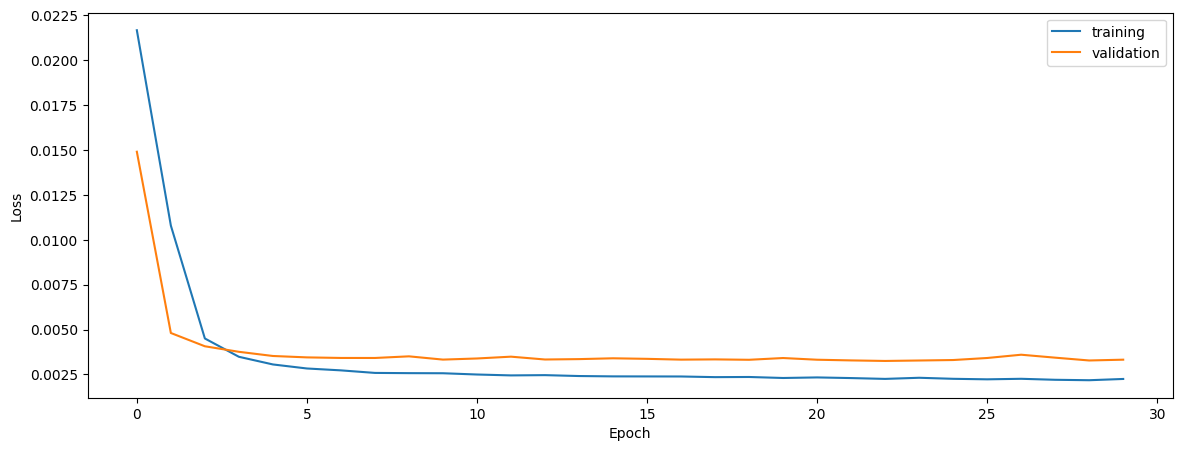

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


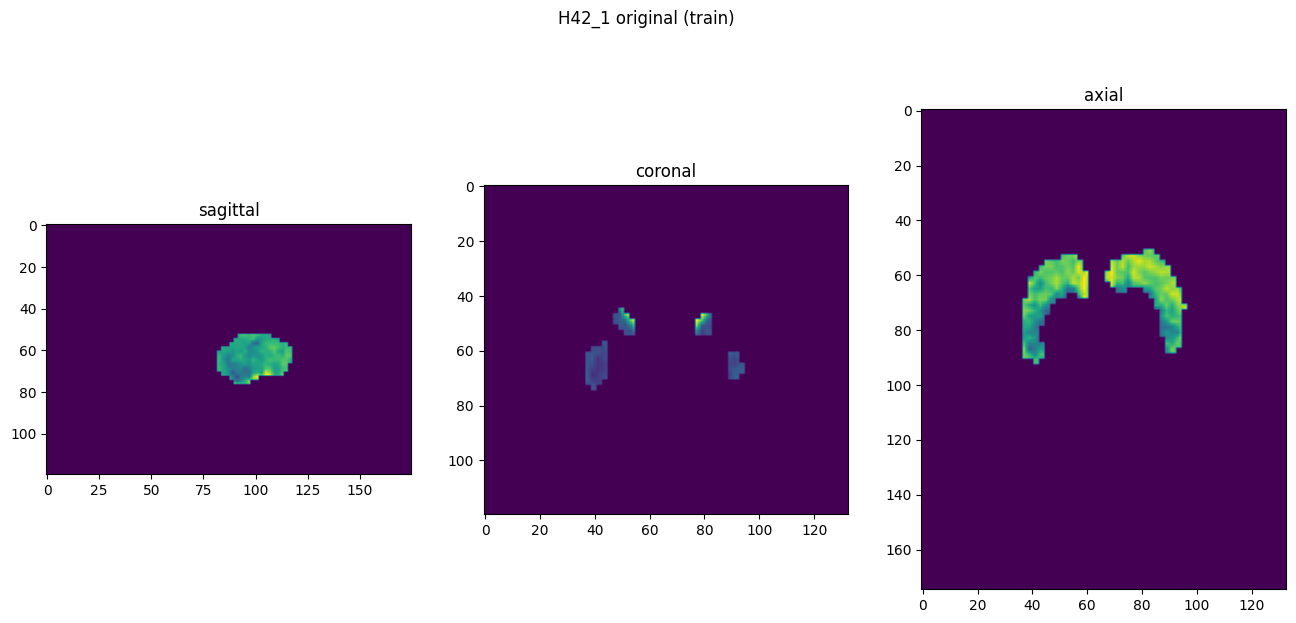

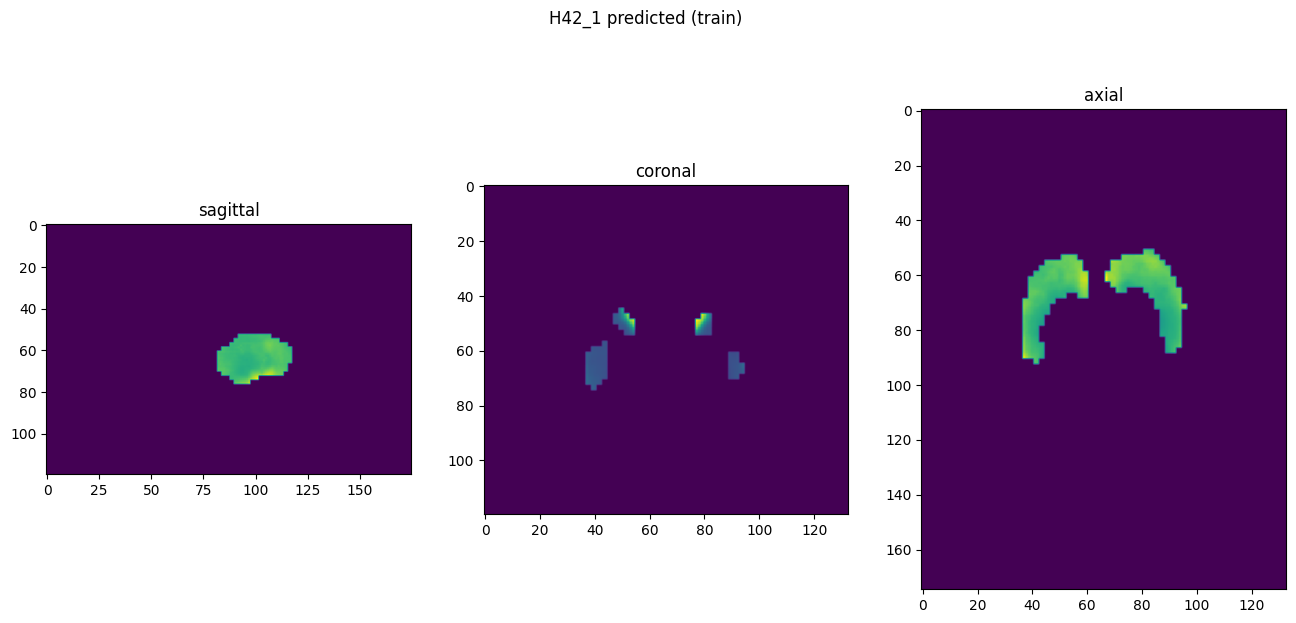

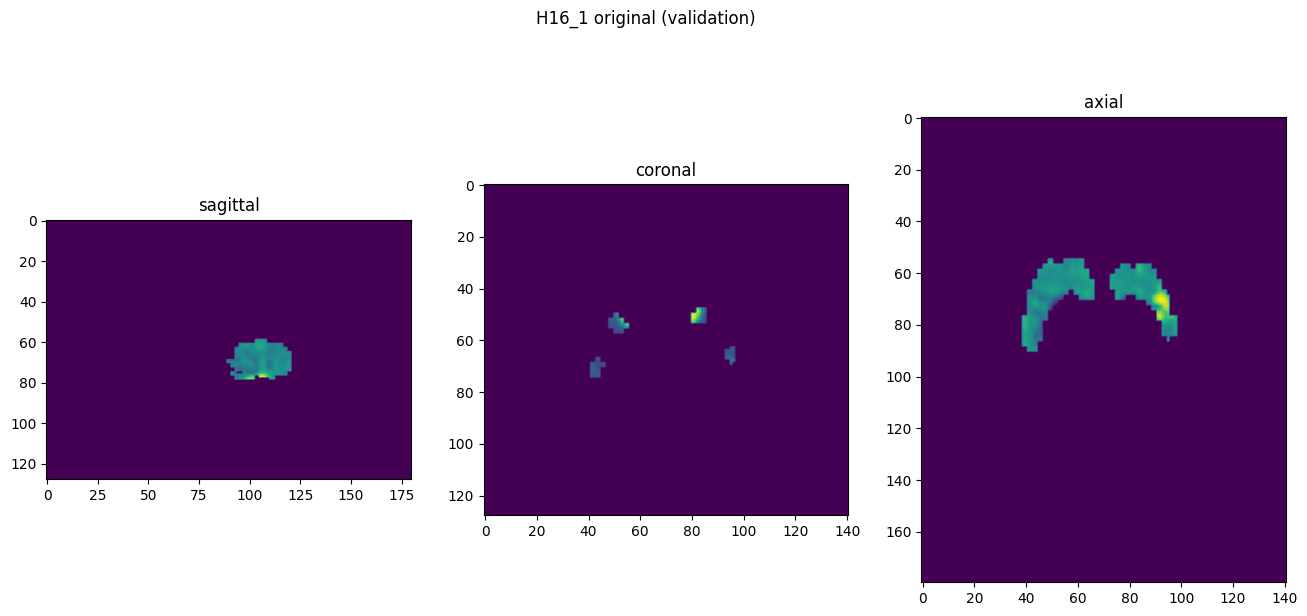

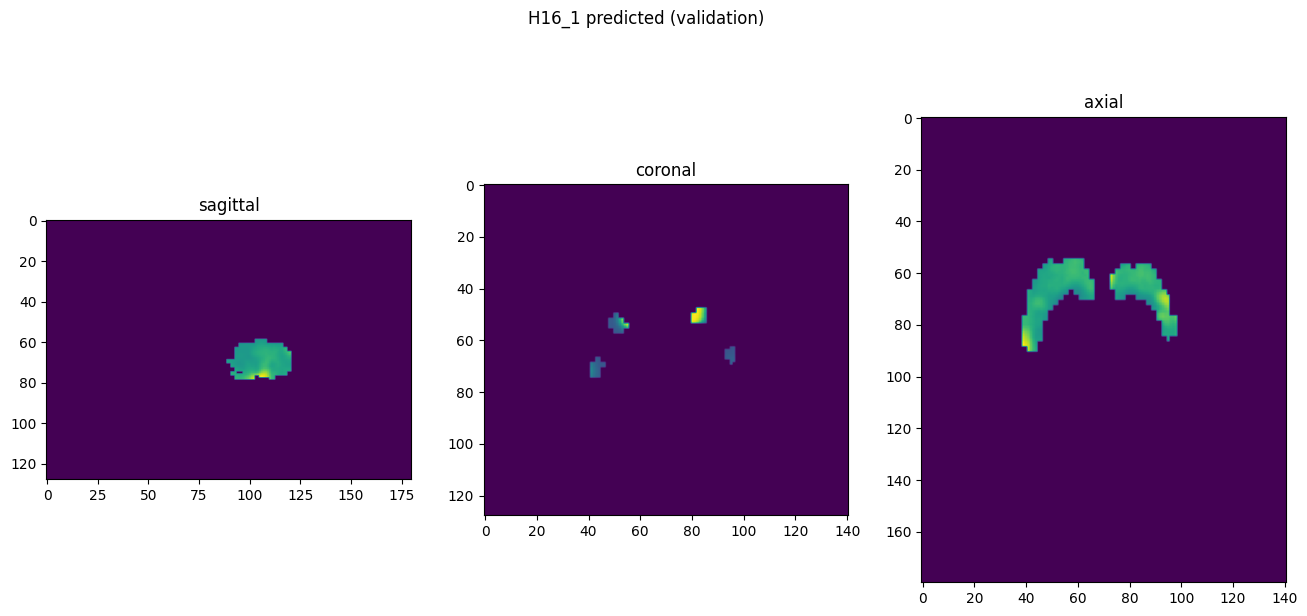

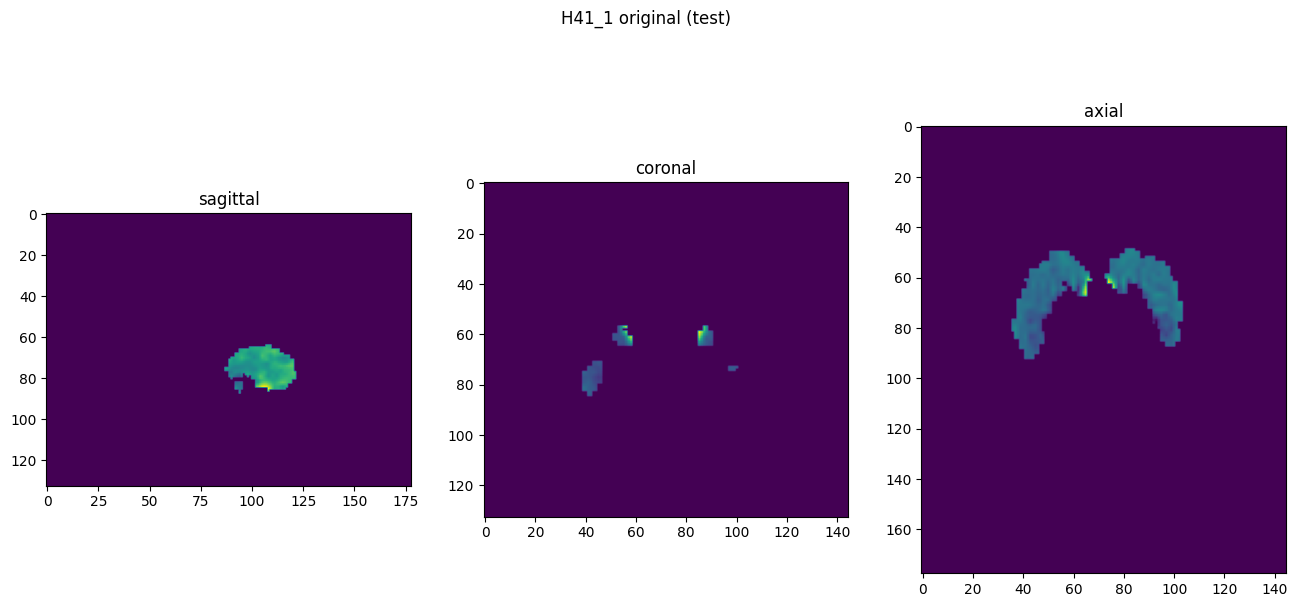

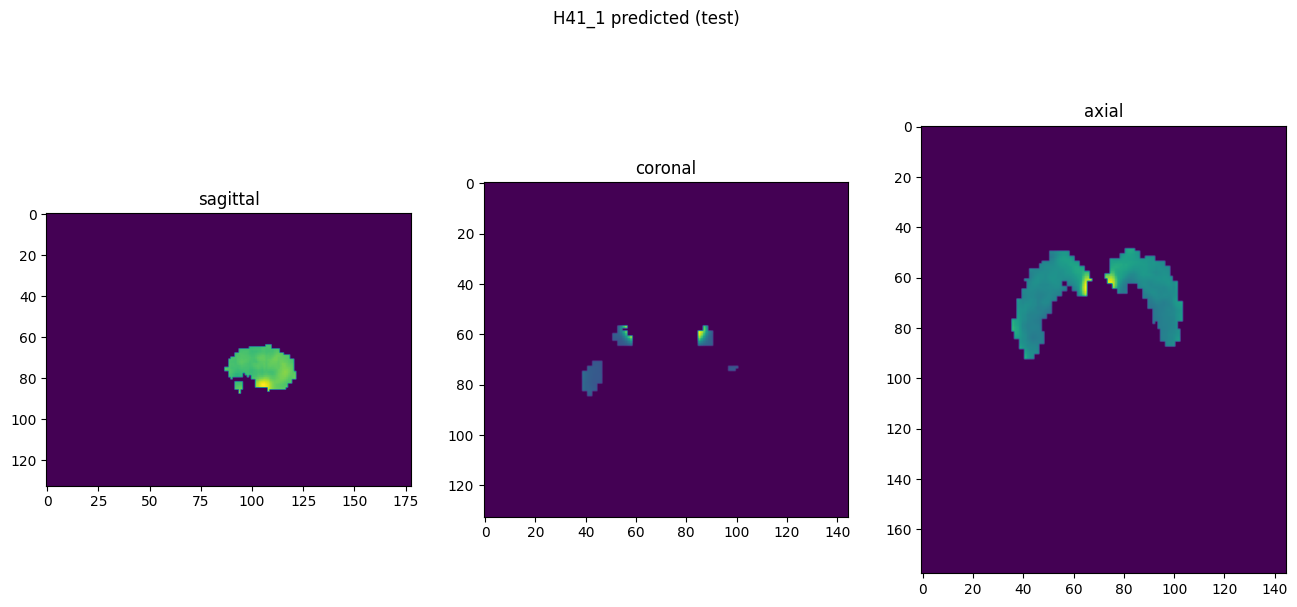

In [10]:
showResults(model, gen, threshold=None, background=False)